# Lithium Response predictor


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

In [14]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [15]:
def plot_roc(classifiers, X_test, y_test) : 
    
    for clf in classifiers: 
        fpr2, tpr2, threshold = roc_curve(y_test,  clf['model'].predict_proba(X_test)[:,1])
        # area under curve
        roc_auc = auc(fpr2, tpr2)

        plt.plot(
            fpr2,
            tpr2,
            lw=2,
            label="{} (AUC={:.2f})".format(clf['name'],roc_auc),)

    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    # plt.show()
    return plt

### Data Load

In [16]:
# df = pd.read_csv('LiResp_dataset.csv', index_col=0)


In [17]:
# Load saved classifiers and apply best params
classifiers = pickle.load( open( "classifiers_gridSearch.p", "rb" ) )
for clf in classifiers: 
    clf['model'].set_params(**clf['best_params_'])

## LR vs. NR

In [18]:

imag_prefix = 'BD_vs_Ctrl - '
# imag_prefix = 'LR_vs_NR - '

### Split into train and test dataset 

In [19]:
if 'LR_vs_NR' in imag_prefix : 
    df = pd.read_csv('LiResp_dataset.csv', index_col=0)
    train_df = df[df['batch']<4]
    X_train = np.array(train_df.drop(columns=['batch','condition']))
    y_train = np.array(train_df['condition'].apply(lambda x : 1 if x =='LR' else 0))

    test_df = df[df['batch']==4]
    X_test = np.array(test_df.drop(columns=['batch','condition']))
    y_test = np.array(test_df['condition'].apply(lambda x : 1 if x =='LR' else 0))

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    print([x.shape for x in (X_train, y_train, X_test,y_test)])
    
    
if 'BD_vs_Ctrl' in  imag_prefix : 
    
    samples_df = pd.read_csv(r'samples_joined.csv', index_col=0)
    samples_df.drop(columns=['patient', 'sex','age'], inplace=True)
    # import count matrix
    countMatrix_df = pd.read_csv('countMatrix_include_gene_name.csv', index_col=0).T
    df_full =  countMatrix_df.merge(samples_df, left_index=True, right_index= True)
    
    #import list of genes from deseq2 analysis
    genes = pd.read_csv('original_dataset_CTRL_vs_BD_counts_results_FC1.csv', index_col=0).T.columns

    # keep only relevant dataset, i.e. drop batch #4 becuase it has no control
    df = df_full[df_full['batch']!= 4]
    # df = df_full.copy()
    
    ##  filter only relevant genes from deseq2 analysis ##
    df = df.loc[:,list(genes) + ['diagnosis']]
    df['diagnosis'] = df['diagnosis'].apply(lambda x : 1 if x =='BD' else 0)
    df.to_csv('BP_vsCtrl_dataset.csv')
    
    
    df = pd.read_csv('BP_vsCtrl_dataset.csv', index_col=0)
    X = np.array(df.drop(columns=['diagnosis']))
    X=  StandardScaler().fit_transform(X)
    # factoring y to 0/1
    y = np.array(df['diagnosis'])
    # split to train/test dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=10)
    print([x.shape for x in (X_train, y_train, X_test,y_test)])

[(27, 1362), (27,), (19, 1362), (19,)]


In [20]:
# fit tarin data and predict to test dataset

for clf in classifiers: 
    clf['model'].fit(X_train, y_train)
    clf['score'] = clf['model'].score(X_test, y_test)
    
    

Iteration 1, loss = 0.69294421
Iteration 2, loss = 0.26716233
Iteration 3, loss = 0.10592137
Iteration 4, loss = 0.05001309
Iteration 5, loss = 0.02905659
Iteration 6, loss = 0.01989370
Iteration 7, loss = 0.01515695
Iteration 8, loss = 0.01233840
Iteration 9, loss = 0.01047291
Iteration 10, loss = 0.00914392
Iteration 11, loss = 0.00815965
Iteration 12, loss = 0.00742499
Iteration 13, loss = 0.00687871
Iteration 14, loss = 0.00646874
Iteration 15, loss = 0.00615176
Iteration 16, loss = 0.00589597
Iteration 17, loss = 0.00567976
Iteration 18, loss = 0.00548911
Iteration 19, loss = 0.00531592
Iteration 20, loss = 0.00515725
Iteration 21, loss = 0.00501398
Iteration 22, loss = 0.00488806
Iteration 23, loss = 0.00477982
Iteration 24, loss = 0.00468765
Iteration 25, loss = 0.00460906
Iteration 26, loss = 0.00454165
Iteration 27, loss = 0.00448329
Iteration 28, loss = 0.00443213
Iteration 29, loss = 0.00438659
Iteration 30, loss = 0.00434535
Iteration 31, loss = 0.00430740
Iteration 32, los

In [21]:
for clf in classifiers: 
    print(clf['score'])

0.8947368421052632
1.0
1.0
0.6842105263157895


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


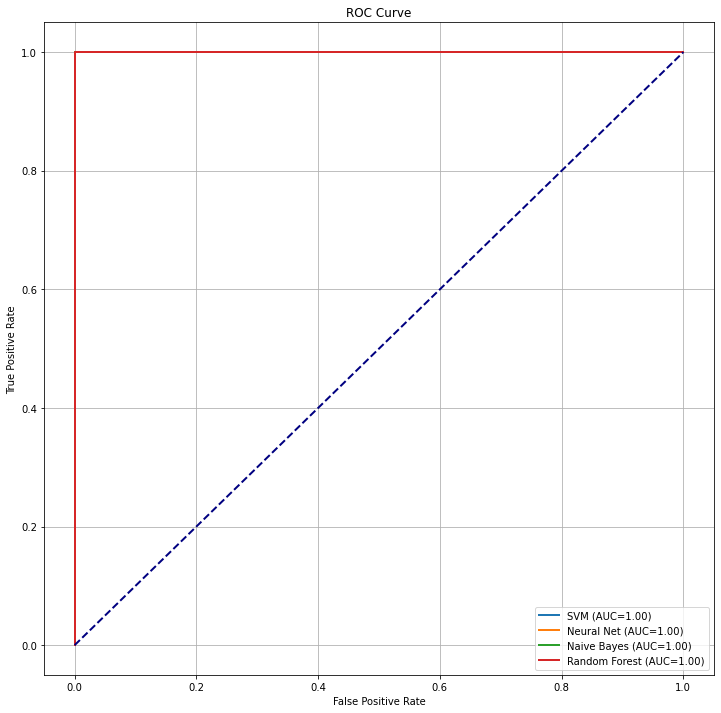

In [22]:
plt.figure(figsize=(12,12))   
plt.grid()
plt = plot_roc(classifiers[:], X_test, y_test)
plt.savefig(imag_prefix + "joined ROC Curve.eps", format='eps',dpi=300)
plt.show()


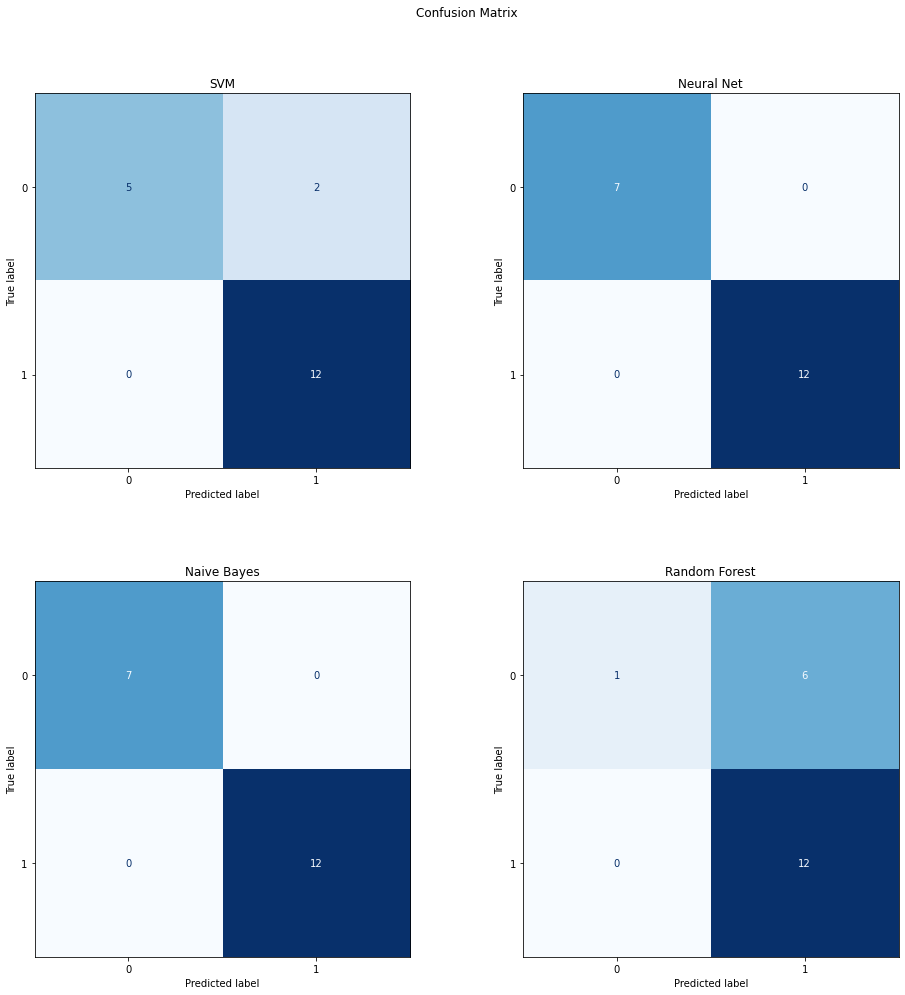

In [23]:
fig, axes = plt.subplots(2,2, figsize=(15,15), )
for k, ax in enumerate(axes.ravel()): 
    clf = classifiers[k]
    
    y_pred = clf['model'].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar = None, cmap=plt.cm.Blues)
    # ConfusionMatrixDisplay.from_estimator( clf['model'], X_test, y_test, ax = ax, colorbar = None, cmap=plt.cm.Blues)
    ax.set_title(clf['name'])
    
    
    
fig.suptitle('Confusion Matrix')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
    

plt.savefig(imag_prefix + "Confusion Matrix.eps", format='eps',dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


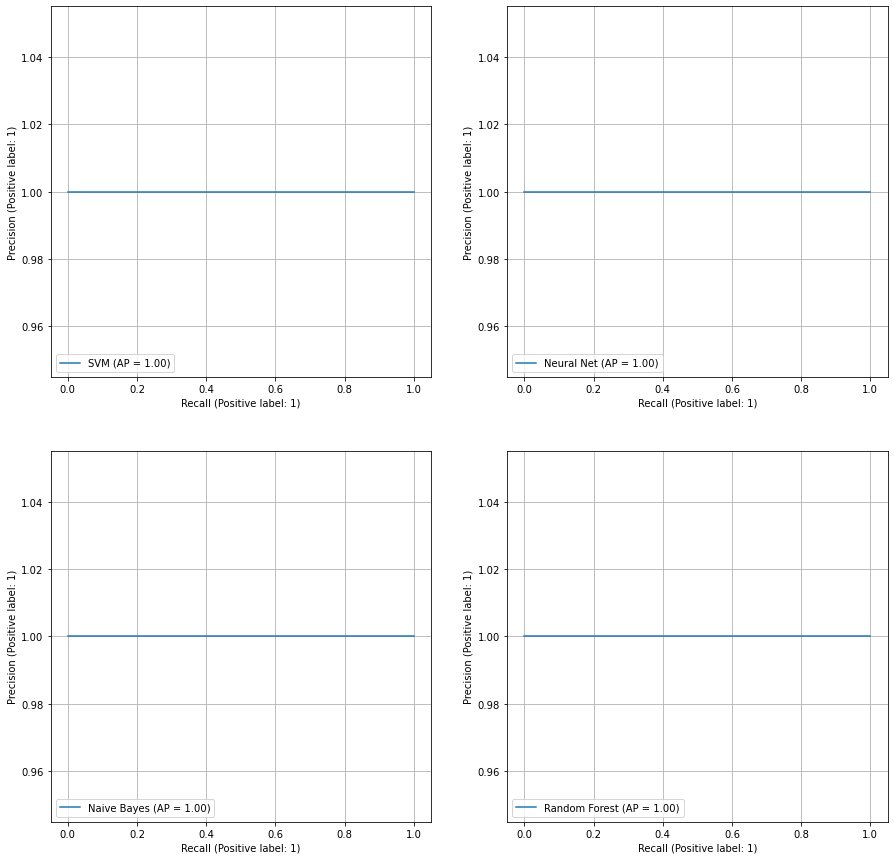

In [12]:
fig, axes = plt.subplots(2,2, figsize=(15,15), )
for k, ax in enumerate(axes.ravel()): 
    clf = classifiers[k]
    ax.grid()
    display = PrecisionRecallDisplay.from_estimator(
                        clf['model'], X_test, y_test, name=clf['name'], ax=ax)
    
    # display.plot(ax=ax)
    
plt.savefig(imag_prefix + "Precision Recal Curve.eps", format='eps',dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


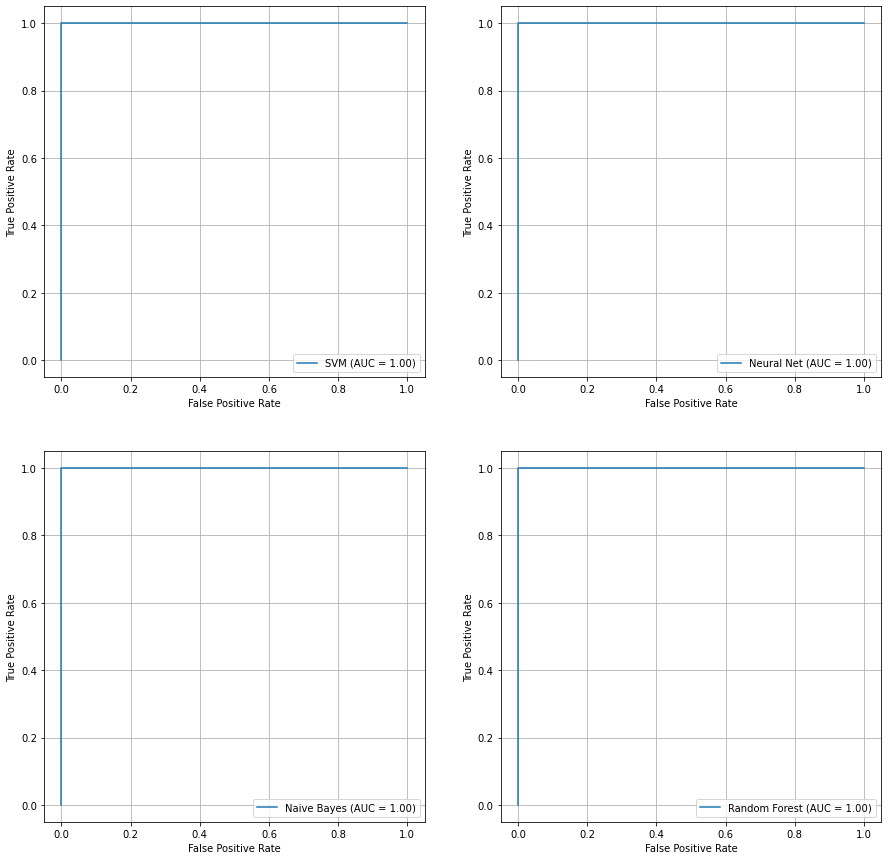

In [14]:
fig, axes = plt.subplots(2,2, figsize=(15,15), )
for k, ax in enumerate(axes.ravel()): 
    clf = classifiers[k]
    # y_pred = clf['model'].decision_function(X_test)
    # plot_roc([classifiers[k]], X_test, y_test, ax=ax)
    fpr, tpr, thresholds = roc_curve(y_test,  clf['model'].predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    ax.grid()
    display= RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name=clf['name'])
    display.plot(ax=ax)
    
plt.savefig(imag_prefix + "splitted ROC Curve.eps", format='eps',dpi=300)

### Cross Validation - joined Dataset

In [15]:
if 'LR_vs_NR' in imag_prefix : 
    X = np.array(df.drop(columns=['batch','condition']))
    y = np.array(df['condition'].apply(lambda x : 1 if x =='LR' else 0))
    X = StandardScaler().fit_transform(X)

    [x.shape for x in (X, y)]

In [25]:
cv = ShuffleSplit(n_splits=40, test_size=0.4, random_state=0)

for clf in classifiers: 
    clf['cv_scores'] = cross_val_score(clf['model'],X, y, cv=cv, scoring='accuracy', n_jobs=8  )
    
scores_df=[]
for k, row in  pd.DataFrame(classifiers).iterrows(): 
    [scores_df.append({'model':row['name'], 'score':x}) for x in row['cv_scores']]
    

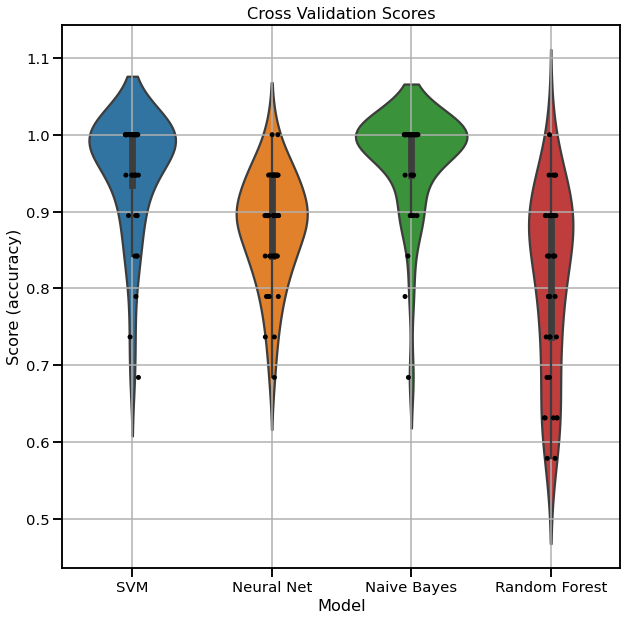

In [26]:
sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(10,10))

sns.violinplot(x="model", 
                y="score", 
                data=pd.DataFrame(scores_df))
sns.stripplot(x="model", 
                y="score", 
                data=pd.DataFrame(scores_df), 
                color="black", edgecolor="gray", jitter=0.05)
plt.ylabel('Score (accuracy)')
plt.xlabel('Model')
plt.grid()
plt.title('Cross Validation Scores')

plt.savefig(imag_prefix + "Cross Validation Scores.eps", format='eps',dpi=300)

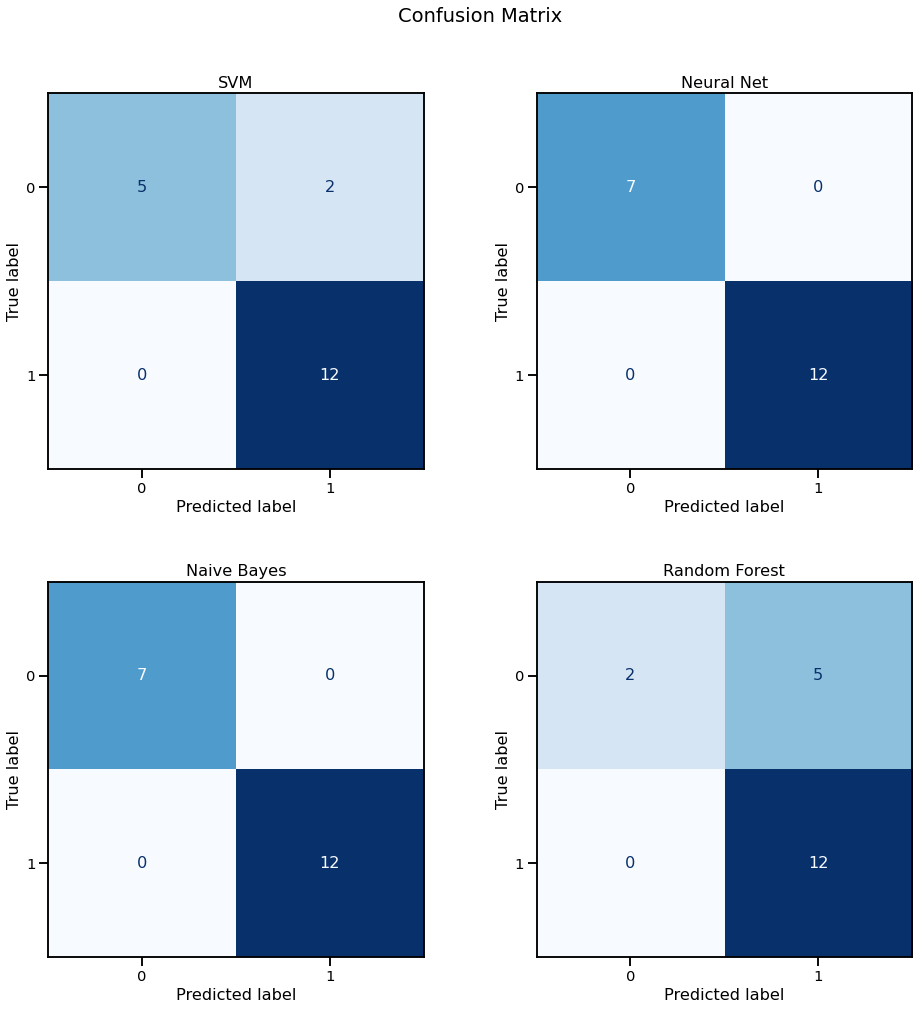

In [18]:
fig, axes = plt.subplots(2,2, figsize=(15,15), )
for k, ax in enumerate(axes.ravel()): 
    clf = classifiers[k]
    ConfusionMatrixDisplay.from_estimator( clf['model'], X_test, y_test, ax = ax, colorbar = None, cmap=plt.cm.Blues)
    ax.set_title(clf['name'])
fig.suptitle('Confusion Matrix')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
    

plt.savefig(imag_prefix + "Confusion Matrix.eps", format='eps',dpi=150)

In [9]:
metric_list = ['accuracy', 'precision', 'f1', 'roc_auc']

In [11]:
cv = ShuffleSplit(n_splits=40, test_size=0.4, random_state=0)

for clf in classifiers: 
    for metric in metric_list:
        clf[metric] = cross_val_score(clf['model'],X, y, cv=cv, scoring=metric, n_jobs=8  )

In [12]:
scores_df=[]
for clf in classifiers: 
    for metric in metric_list:
        for v in clf[metric]: 
            scores_df.append({'model':clf['name'], 
                              'metric':metric, 
                              'value':v})
scores_df =pd.DataFrame(scores_df)        
        

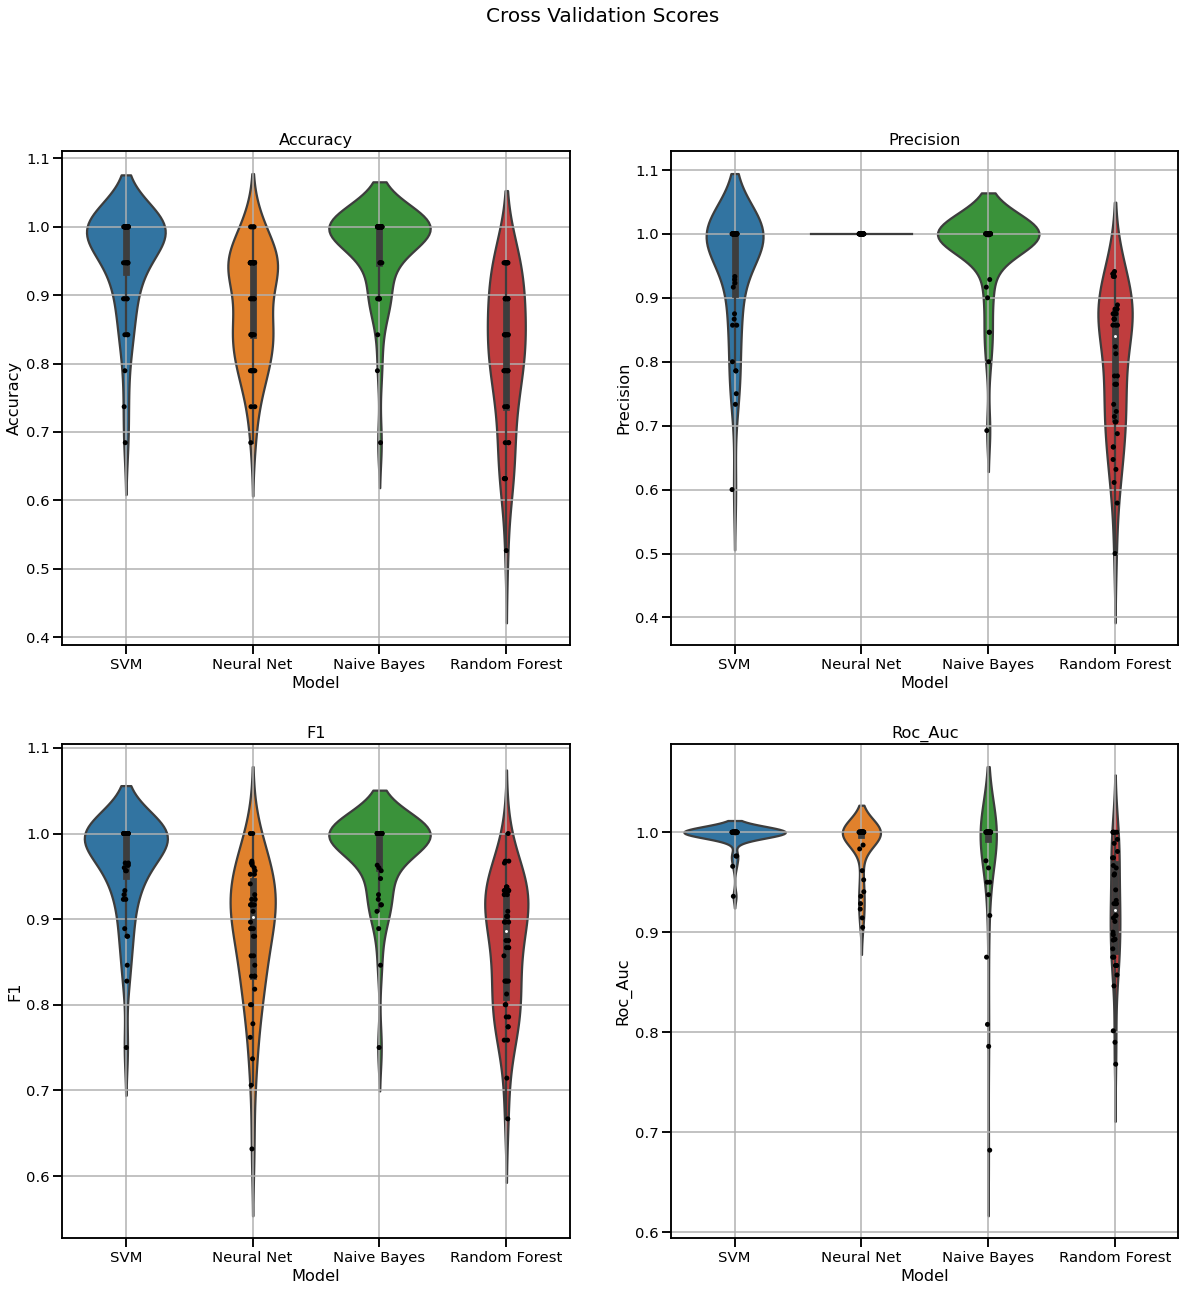

In [30]:
sns.set_context("talk", font_scale=0.9)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
axes_flatten=axes.ravel()
for k, metric in enumerate(metric_list):
    ax=axes_flatten[k]
    sns.violinplot(y="value", x="model",
                    data=scores_df[scores_df['metric']==metric], ax=ax)
    
    sns.stripplot(y="value", x="model",
                    data=scores_df[scores_df['metric']==metric], 
                    color="black", edgecolor="gray", jitter=0.02, ax=ax)
    
    ax.set_ylabel(metric.title())
    ax.set_title(metric.title())
    ax.set_xlabel('Model')
    ax.grid()
fig.suptitle('Cross Validation Scores', size=20)
plt.savefig(imag_prefix + "Cross Validation Scores.eps", format='eps',dpi=300)
plt.show()